**Explore differentially expressed genes**  
This part will asssume that you have a list of differentially expressed genes already generated.  
Lets start with reading in some data to our session

In [1]:
suppressMessages(library(DESeq2)) # load the DESeq2 package

In [2]:
counts <- read.delim("data/counts.txt", sep="\t", check.names=FALSE, as.is=TRUE)

In [3]:
sample.info <- read.delim("data/sample_info.txt", sep="\t", check.names=FALSE)

In [4]:
model <- read.delim("data//diffexpr-results.csv", sep="\t", check.names=FALSE)

In [5]:
head(model)

,gene_name,gene_biotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000091972,CD200,protein_coding,308.88085,3.655514,0.2549227,14.24852,4.578529e-46,8.232652e-42
ENSG00000187601,MAGEH1,protein_coding,502.70770,3.161066,0.2713160,11.62730,2.994322e-31,2.692045e-27
ENSG00000235304,LINC01281,lincRNA,82.04318,4.885393,0.3725763,11.40383,4.001298e-30,2.398245e-26
ENSG00000125538,IL1B,protein_coding,1089.90272,-1.868674,0.1713032,-10.90638,1.074530e-27,4.830280e-24
ENSG00000003147,ICA1,protein_coding,449.93853,3.382331,0.3211397,10.50644,8.068215e-26,2.901491e-22
ENSG00000149257,SERPINH1,protein_coding,1233.86635,3.537105,0.3401214,10.40155,2.439450e-25,7.310624e-22


Subset data to significant genes and variance transform data (rlog)

In [6]:
?rlog

rlog {DESeq2},R Documentation
object,"a DESeqDataSet, or matrix of counts"
blind,"logical, whether to blind the transformation to the experimental design. blind=TRUE should be used for comparing samples in an manner unbiased by prior information on samples, for example to perform sample QA (quality assurance). blind=FALSE should be used for transforming data for downstream analysis, where the full use of the design information should be made. blind=FALSE will skip re-estimation of the dispersion trend, if this has already been calculated. If many of genes have large differences in counts due to the experimental design, it is important to set blind=FALSE for downstream analysis."
intercept,"by default, this is not provided and calculated automatically. if provided, this should be a vector as long as the number of rows of object, which is log2 of the mean normalized counts from a previous dataset. this will enforce the intercept for the GLM, allowing for a ""frozen"" rlog transformation based on a previous dataset. You will also need to provide mcols(object)$dispFit."
betaPriorVar,"a single value, the variance of the prior on the sample betas, which if missing is estimated from the data"
fitType,"in case dispersions have not yet been estimated for object, this parameter is passed on to estimateDispersions (options described there)."


In [7]:
counts <- counts[rownames(model),]

In [8]:
de <- DESeqDataSetFromMatrix(as.matrix(round(counts)), colData = sample.info, design=~Sample_Group)

converting counts to integer mode
  it appears that the last variable in the design formula, 'Sample_Group',
  has a factor level, 'Control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').


In [9]:
dat <- rlog(de, blind=FALSE)

In [10]:
head(dat)

class: DESeqTransform 
dim: 6 10 
metadata(1): version
assays(1): ''
rownames(6): ENSG00000091972 ENSG00000187601 ... ENSG00000003147
  ENSG00000149257
rowData names(7): baseMean baseVar ... dispFit rlogIntercept
colnames(10): 6a 8a ... B5 B6
colData names(6): Sample_Biosource Concentration ... Sample_Group
  sizeFactor

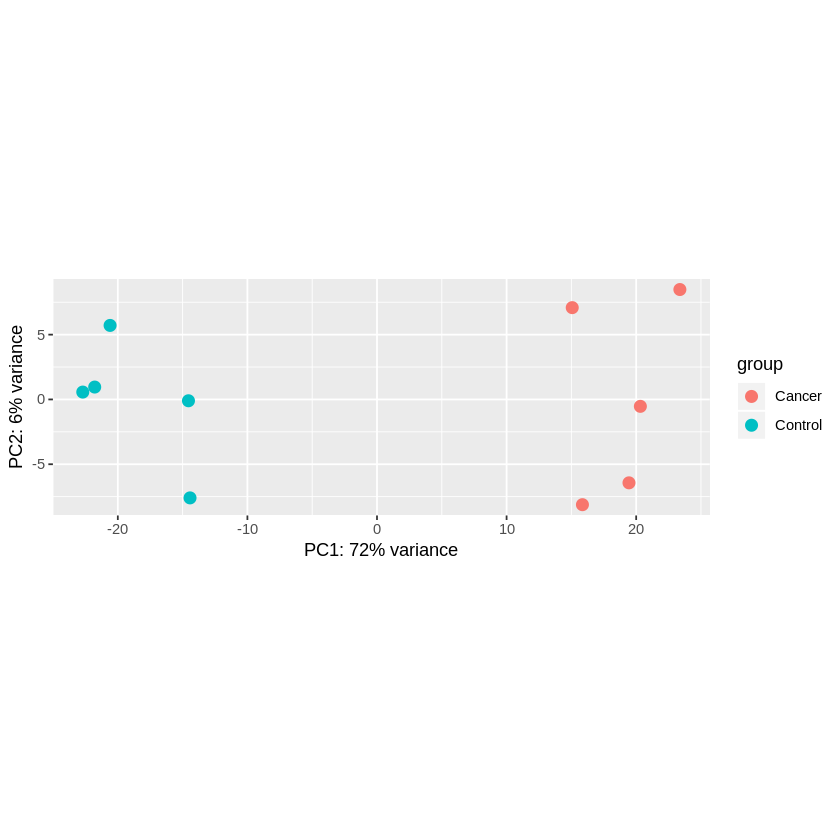

In [11]:
plotPCA(dat, intgroup="Sample_Group")